In [168]:
from netCDF4 import Dataset
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 5]

### Read COSMO-1 topography

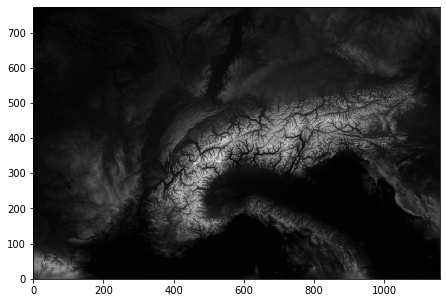

In [169]:
nc = Dataset("hsurf.nc", "r")
hsurf = nc.variables["HSURF"][:]
nc.close()
plt.imshow(hsurf, origin='lower', cmap='gray')
ny, nx = hsurf.shape

### Smooth orography (for SLEVE)

In [170]:
nfltvc = 100
hsurfs = hsurf.copy()
tmp = hsurf.copy()
for n in range(nfltvc):
    for j in range(1, ny-1):
        tmp[j,1:nx-1]= 0.25 * hsurfs[j,1:nx-1] \
            + 0.125  * ( hsurfs[j,   0:nx-2] + hsurfs[j,   2:nx] \
                       + hsurfs[j-1, 1:nx-1] + hsurfs[j+1, 1:nx-1] ) \
            + 0.0625 * ( hsurfs[j-1, 0:nx-2] + hsurfs[j-1, 2:nx] \
                       + hsurfs[j+1, 0:nx-2] + hsurfs[j+1, 2:nx] )
            
    # corner points
    tmp[0,0] =  0.25 * \
            ( hsurfs[0, 0] + hsurfs[0, 1] \
            + hsurfs[1, 0] + hsurfs[1, 1] )

    tmp[-1, 0] =  0.25 * \
            ( hsurfs[-1, 0] + hsurfs[-1, 1] \
            + hsurfs[-2, 0] + hsurfs[-2, 1] )

    tmp[0, -1] =  0.25 * \
            ( hsurfs[0, -1] + hsurfs[0, -2] \
            + hsurfs[1, -1] + hsurfs[1, -2] )
    tmp[-1, -1] =  0.25 * \
            ( hsurfs[-1, -1] + hsurfs[-1, -2] \
            + hsurfs[-2, -1] + hsurfs[-2, -2] )
    
    # edge points
    tmp[1:ny-1, 0] = \
        0.25  * ( hsurfs[1:ny-1, 0] + hsurfs[1:ny-1, 1] ) \
     +  0.125 * ( hsurfs[0:ny-2, 0] + hsurfs[2:ny, 0]  \
                + hsurfs[0:ny-2, 1] + hsurfs[2:ny, 1] )


    tmp[1:ny-1, -1] = \
         0.25  * ( hsurfs[1:ny-1, -1] + hsurfs[1:ny-1, -2] ) \
      +  0.125 * ( hsurfs[0:ny-2, -1] + hsurfs[2:ny, -1] \
                 + hsurfs[0:ny-2, -2] + hsurfs[2:ny, -2] )
    
    hsurfs[:] = tmp

hsurfs1 = hsurfs
hsurfs2 = hsurf - hsurfs1

### Extract 2d-slice of topography

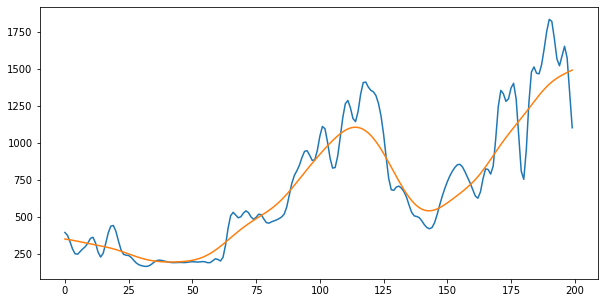

In [171]:
topo = hsurf[400, 300:500]
topos1 = hsurfs1[400, 300:500]
topos2 = hsurfs2[400, 300:500]
plt.plot(topo)
plt.plot(topos1)

### Define vertical z-level distribution of COSMO-1

In [172]:
lev = np.array([    0.0000,    20.0000,    40.0700,    60.3900,    81.1300,   102.5100,   124.7300,   148.0000,   172.5400,   198.5700,
         226.3300,   256.0398,   287.9299,   322.2400,   359.2100,   399.0898,   442.1099,   488.5198,   538.5698,   592.5200,
         650.6099,   713.0898,   780.2300,   852.2800,   929.4900,  1012.1399,  1100.4800,  1194.7700,  1295.2800,  1402.2700,
        1516.0200,  1636.7800,  1764.8398,  1900.4500,  2043.8999,  2195.4500,  2355.3799,  2523.9600,  2701.4800,  2888.2000,
        3084.3999,  3290.3601,  3506.3701,  3732.7000,  3969.6399,  4217.4570,  4476.4570,  4746.9102,  5029.0898,  5323.3086,
        5629.8281,  5948.9570,  6280.9688,  6626.1484,  6984.7969,  7357.2070,  7743.6602,  8144.4492,  8559.8672,  8990.2070,
        9435.7695,  9896.8398, 10373.7070, 10866.6875, 11376.0586, 11902.1289, 12445.1875, 13005.5273, 13583.4688, 14179.2891,
       14793.2969, 15425.7969, 16077.0781, 16747.4492, 17437.2188, 18146.6797, 18876.1289, 19625.8906, 20396.2500, 21187.5195,
       22000.0000])
vcflat = 11357.0000
svc1 = 10000.0
svc2 = 3300.0
zn = 1.35

### Determine vertical coordinates (SLEVE2)

In [173]:
# vertical decay functions
ak  = lev
bk1 = np.sinh( (vcflat/svc1)**zn - (lev/svc1)**zn ) / \
      np.sinh( (vcflat/svc1)**zn )
bk2 = np.sinh( (vcflat/svc2)**zn - (lev/svc2)**zn ) / \
      np.sinh( (vcflat/svc2)**zn )

# flat for z > vcflat
ak[lev > vcflat] = lev[lev > vcflat]
bk1[lev > vcflat] = 0.0
bk2[lev > vcflat] = 0.0

(200, 3000)

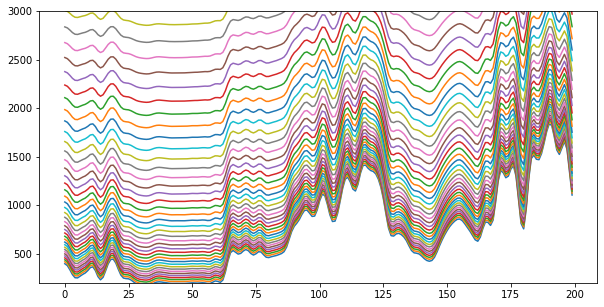

In [174]:
# construct SLEVE cooridinates
hhl = np.empty([len(lev), len(topo)])
hhl[0, :] = topo[:]
plt.plot(hhl[0, :])
for k in range(1, len(lev)):
    hhl[k, :] = ak[k] + bk1[k] * topos1 + bk2[k] * topos2
    plt.plot(hhl[k, :])
plt.ylim(200, 3000)

### Locally smoothed vertical coordinate (LOSVEC)

In [175]:
# vertical decay functions (Gal-Chen)
ak = lev
bk = (vcflat - lev) / vcflat

# flat for z > vcflat
ak[lev > vcflat] = lev[lev > vcflat]
bk[lev > vcflat] = 0.0

In [176]:
# local smoother (with local masking)
def smooth_level(level, level_below, dz_ref, niter=10, coeff=0.05):
    mask = 1.0 + 0.0 * level
    tmp = level.copy()
    for n in range(niter):
        x1 = + ( tmp - level_below - 19.0 ) / 2.0              # if levels become much thinner than 19m
        x2 = - ( ( tmp - level_below ) / dz_ref - 1.0 ) / 0.2  # if levels become much thicker than 120% of original dz
        mask = 0.25 * ( 1.0 + np.tanh(x1) ) * ( 1.0 + np.tanh(x2) )
        mask[1:-2] = mask[1:-2] + 0.25 * ( mask[0:-3] - 2.0*mask[1:-2] + mask[2:-1] )
        tmp[1:-2] = level[1:-2] + mask[1:-2] * coeff * ( \
                        level[0:-3] - 2.*level[1:-2] + level[2:-1] )
        level[:] = tmp
    return level

(200, 3000)

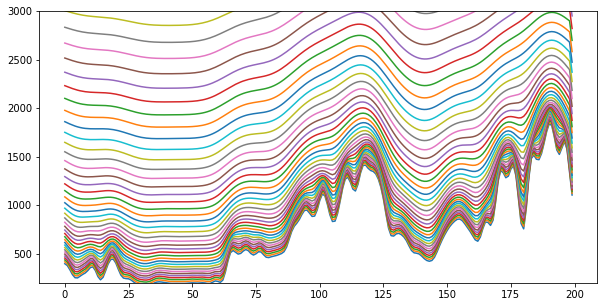

In [177]:
hhl = np.empty([len(lev), len(topo)])
hhl[0, :] = topo[:]
plt.plot(hhl[0, :])
for k in range(1, len(lev)):
    if bk[k] > 0:
        hhl[k, :] = ak[k] + bk[k] / bk[k-1] * ( hhl[k-1, :] - ak[k-1] )
    else:
        hhl[k, :] = ak[k]
    hhl[k, :] = smooth_level( hhl[k, :], hhl[k-1, :], lev[k] - lev[k-1], niter=np.int(1 + k**1.1) )
    plt.plot(hhl[k, :])
plt.ylim(200, 3000)